# Web scraping REPS con Selenium.

Que son los REPS?: Registro Especial de Prestadores de Servicios de Salud -REPS. Es la base de datos de las Entidades Departamentales y Distritales de Salud, en la cual se efectúa el registro de los Prestadores de Servicios de Salud que se encuentren habilitados y es consolidada por parte del Ministerio de Salud y Protección Social [**link**](https://www.minsalud.gov.co/sites/rid/Lists/BibliotecaDigital/RIDE/DE/PES/caracterizacion-registro-especial-prestadores-reps.pdf)

Que funcionalidad hace este script: Se encarga de descargar los archivos de:
- Prestadores
- Sedes
- Servicios
- Capacidad

desde la pagina web.

In [1]:
import time
start_i = time.time()

In [2]:
from glob import glob
from lxml import etree
from selenium import webdriver
import datetime, os, gc

In [12]:
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_columns = 200

In [3]:
def clean_not_downloaded(download_path:str, debug:bool=False):
    if debug==True: print(f"fx({clean_not_downloaded.__name__})")
    downloading_chrome  = glob(download_path+'\\*.crdownload')
    downloading_firefox = glob(download_path+'\\*.part')
    files = downloading_chrome+downloading_firefox
    if len(files)>0:
        for f in files:
            try:
                os.remove(f)
                if debug==True: print(f"\tfile deleted {f}")
            except:
                pass
    return

In [4]:
def wait_til_download(download_path:str, debug:str=False):
    """
        wait til download files
    """
    if debug==True: print(f"fx({wait_til_download.__name__})")
    downloading = 1
    while downloading>0:
        time.sleep(5)
        downloading_chrome  = glob(download_path+'\\*.crdownload')
        downloading_firefox = glob(download_path+'\\*.part')
        # print(downloading_chrome + downloading_firefox)
        downloading = len(downloading_chrome + downloading_firefox)
    time.sleep(30)
    return

In [5]:
def get_last_downloaded_file(download_path:str, prefix_file:str=None, debug:bool=False):
    if debug==True: print(f"fx({get_last_downloaded_file.__name__})")
    if prefix_file==None:
        path = download_path+'\\*'
    else:
        path = download_path+f'\\{prefix_file}*'
    files = [(f, os.path.getmtime(f)) for f in glob(path)]
    files.sort(key=lambda a: a[1], reverse=True)
    last_file = files[0][0]
    k = os.path.basename(last_file).split(".")[0].split("(")[0].strip()
    return k, last_file

In [6]:
def get_last_files_donloaded(download_path:str, debug:bool=False):
    """
        Get all last files downloaded
    """
    if debug==True: print(f"fx({get_last_files_donloaded.__name__})")
    downloaded_files = dict()
    for k in set([os.path.basename(f).split(".")[0].split("(")[0].strip() for f in glob(download_path+'/*')]):
        _, last_file = get_last_downloaded_file(download_path=download_path, prefix_file=k)
        downloaded_files.update({k: last_file})
    return downloaded_files

In [7]:
def make_download_path(download_path:str=None, debug:bool=False):
    if debug==True: print(f"fx({make_download_path.__name__})")
    if download_path==None:
        download_path = os.path.join(os.getcwd(), "downloads")
    else:
        try:
            os.path.exists(download_path)
        except:
            try:
                os.makedirs(download_path)
            except Exception as e:
                e = f"\tcan't make path.\n\t{download_path}\nError: {e}"
                raise Exception(e)
    return download_path

In [8]:
def make_options(download_path:str, kind_of_browser:str="firefox", debug:bool=False):
    if debug==True: print(f"fx({make_options.__name__})")

    if kind_of_browser=="firefox":
        
        options = webdriver.firefox.options.Options()
        options.set_preference('--headless')
        options.set_preference("browser.download.manager.showWhenStarting", False)
        options.set_preference("browser.download.dir", download_path)
        options.set_preference("browser.helperApps.neverAsk.saveToDisk", "application/x-gzip")

    elif kind_of_browser=="chrome":
        
        options = webdriver.chrome.options.Options()
        # options.add_argument("--headless")
        options.add_argument('--incognito')
        options.add_argument("--disable-xss-auditor")
        options.add_argument("--disable-web-security")
        options.add_argument("--allow-running-insecure-content")
        options.add_argument("--no-sandbox")
        options.add_argument("--disable-setuid-sandbox")
        options.add_argument("--disable-webgl")
        options.add_argument("--disable-popup-blocking")
        options.add_argument('--disable-gpu')
        
    else:

        e = f"kind_of_browser no es valido [{kind_of_browser}]"
        raise Exception(e)
    
    return options

In [9]:
def start_browser(kind_of_browser:str, options, debug:bool=False):
    if debug==True: print(f"fx({start_browser.__name__})")
    if kind_of_browser=="chrome":
        # browser = webdriver.Chrome(options=options, executable_path=".\drivers\chromedriver")
        try:
            s = webdriver.chrome.service.Service(".\drivers\chromedriver.exe")
            browser = webdriver.Chrome(options=options, service=s)
        except:
            browser = webdriver.Chrome(options=options)
    elif kind_of_browser=="firefox":
        # driver = webdriver.Firefox(firefox_profile=options)
        browser = webdriver.Firefox(options=options)
    else:
        e = f"kind_of_browser no es valido [{kind_of_browser}]"
        raise Exception(e)
    time.sleep(2)
    return browser

In [10]:
def sing_in(browser, url_loggin, debug:bool=False):
    if debug==True: print(f"fx({sing_in.__name__})")
    browser.get(url_loggin)
    time.sleep(3)
    browser.find_element(by="id",value="exampleModal").click()   ### cerrar la ventana emergente
    time.sleep(0.5)
    browser.find_element(by="id",value="Button1").click()        ### ingresar
    time.sleep(0.5)
    return 

In [11]:
def get_download_data(browser, url, debug:bool=False):
    if debug==True: print(f"fx({get_download_data.__name__})")
    browser.get(url)
    time.sleep(0.5)
    browser.find_element(by="id",value="_ctl0_ibBuscarFtr").click()                           ### cargar todos
    time.sleep(2)
    browser.find_element(by="id",value="_ctl0_ContentPlaceHolder1_ibExcel").click()           ### descargar excel
    if debug==True: print("\t",url)
    return

In [12]:
def read_downloaded_file(k:str, f:str, fechaconsulta, debug:bool=False):
    if debug==True: print(f"fx({read_downloaded_file.__name__})")
    try:
        df = pd.read_html(f)
        if debug==True: print("\tReaded by pandas")
        if isinstance(df,pd.DataFrame):
            pass
        elif isinstance(df,list):
            if isinstance(df[0],pd.DataFrame) and df[0].columns[0]==0:
                cols = df[0].iloc[0].values
                df = df[0].iloc[1:]
                df.columns = cols
            else:
                e = f"\tbad structure."
                print(e)
                raise Exception(e)
        else:
            e = f"\tbad structure. not [list] or [pd.DataFrame]"
            print(e)
            raise Exception(e)
    except:
        try:
            with open(f, 'rt') as fo:
                raw = etree.HTML(fo.read()).find("body/table")
                rows = iter(raw)
                headers = [col.text for col in next(rows)]
                values=[]
                for row in rows:
                    values.append([col.text for col in row])
                df = pd.DataFrame(values,columns=headers)
            if debug==True: print("\tReaded by etree")
        except Exception as e:
            e = f"\tno se leyo.. {f}\nError: {e}"
            raise Exception(e)
    if debug==True: print("\ttype(df) = ", type(df))
    df["fechahora_consulta"] = fechaconsulta
    if debug==True: print(f"\t{k}.shape = {df.shape}")
    return df

In [13]:
def save_to_parquet(k:str, df:pd.DataFrame, fechaconsulta, debug:bool=False):
    if debug==True: print(f"fx({save_to_parquet.__name__})")
    try:
        os.makedirs("output")
    except:
        pass
    fName = f'output/{k.lower()}__{fechaconsulta.strftime("%Y%m%d_%H%M%S%f")}.parquet'
    df.to_parquet(fName)
    return fName

## main

In [14]:
url                 = "https://prestadores.minsalud.gov.co/habilitacion"
url_loggin          = f"{url}/work.aspx"
url_prestadores     = f"{url}/consultas/habilitados_reps.aspx"
url_sedes           = f"{url}/consultas/sedes_reps.aspx"
url_servicios       = f"{url}/consultas/serviciossedes_reps.aspx"
url_capacidad       = f"{url}/consultas/capacidadesinstaladas_reps.aspx"
urls                = [url_prestadores, url_sedes, url_servicios, url_capacidad]
kind_of_browser      = "chrome"
downloaded_files    = list()

debug = False    # True

In [ ]:
download_path = make_download_path()
clean_not_downloaded(download_path=download_path)
download_path


In [16]:
%%time
options = make_options(download_path=download_path, kind_of_browser=kind_of_browser, debug=debug)
browser = start_browser(kind_of_browser=kind_of_browser, options=options, debug=debug)
print(f"Browser started ... {kind_of_browser}")

Driver started ... chrome
CPU times: total: 15.6 ms
Wall time: 4.08 s


In [17]:
%%time
sing_in(browser=browser, url_loggin=url_loggin, debug=debug)
print(f"Logging in web ... {url_loggin}")

Logging in web ... https://prestadores.minsalud.gov.co/habilitacion/work.aspx
CPU times: total: 0 ns
Wall time: 5.92 s


In [18]:
%%time
for u in urls:
    # u = urls[0]
    print("*"*50, u)
    start = time.time()
    get_download_data(browser=browser, url=u, debug=debug)
    fechaconsulta = datetime.datetime.now()
    wait_til_download(download_path=download_path, debug=debug)
    k,last_file = get_last_downloaded_file(download_path=download_path, debug=debug)
    downloaded_files.append({k: {"file": last_file, "url":u, "fechahora_consulta": fechaconsulta}})
    time.sleep(5)
    print("\t", round((time.time()-start)/60,2),"min.")
    print("")
browser.close()
browser.quit()

************************************************** https://prestadores.minsalud.gov.co/habilitacion/consultas/habilitados_reps.aspx
	 1.08 min.

************************************************** https://prestadores.minsalud.gov.co/habilitacion/consultas/sedes_reps.aspx
	 1.46 min.

************************************************** https://prestadores.minsalud.gov.co/habilitacion/consultas/serviciossedes_reps.aspx
	 5.52 min.

************************************************** https://prestadores.minsalud.gov.co/habilitacion/consultas/capacidadesinstaladas_reps.aspx
	 1.79 min.

CPU times: total: 141 ms
Wall time: 9min 53s


In [3]:
try:
    if len(downloaded_files)==0: raise Exception
except:
    downloaded_files = get_last_files_donloaded(download_path)
downloaded_files

[{'Prestadores': {'file': 'downloads/Prestadores.xls',
   'url': 'https://prestadores.minsalud.gov.co/habilitacion/consultas/habilitados_reps.aspx',
   'fechahora_consulta': datetime.datetime(2023, 1, 25, 14, 57, 31, 205343)}},
 {'Sedes': {'file': 'downloads/Sedes.xls',
   'url': 'https://prestadores.minsalud.gov.co/habilitacion/consultas/sedes_reps.aspx',
   'fechahora_consulta': datetime.datetime(2023, 1, 25, 14, 58, 43, 548117)}},
 {'Servicios': {'file': 'downloads/Servicios.xls',
   'url': 'https://prestadores.minsalud.gov.co/habilitacion/consultas/serviciossedes_reps.aspx',
   'fechahora_consulta': datetime.datetime(2023, 1, 25, 15, 1, 4, 392393)}},
 {'CapacidadInstalada': {'file': 'downloads/CapacidadInstalada.xls',
   'url': 'https://prestadores.minsalud.gov.co/habilitacion/consultas/capacidadesinstaladas_reps.aspx',
   'fechahora_consulta': datetime.datetime(2023, 1, 25, 15, 5, 57, 315210)}}]

In [20]:
# read and save in parquet
for x in downloaded_files:
    start = time.time()
    k = list(x.keys())[0]
    f = list(x.values())[0]["file"]
    fechaconsulta = list(x.values())[0]["fechahora_consulta"]
    print("*"*50, k)
    df = read_downloaded_file(k=k, f=f, fechaconsulta=fechaconsulta, debug=debug)
    save_to_parquet(k=k, df=df, fechaconsulta=fechaconsulta, debug=debug)
    t = time.time()-start
    if t>60:
        t = f"{round((t/60),1)}min."
    else:
        t = f"{round(t,0)}seg."
    print(f"\teplased time = {t}")

************************************************** Prestadores
	eplased time = 34.0seg.
************************************************** Sedes
	eplased time = 59.0seg.
************************************************** Servicios
	eplased time = 2.1min.
************************************************** CapacidadInstalada
	eplased time = 53.0seg.


In [7]:
print("Files in parquet for fast access.")
files = glob("output/*.parquet")
files

Files in parquet for fast access.


['output\\capacidadinstalada__20230125_150557315210.parquet',
 'output\\prestadores__20230125_145731205343.parquet',
 'output\\sedes__20230125_145843548117.parquet',
 'output\\servicios__20230125_150104392393.parquet']

In [10]:
data = dict()
for f in files:
    k = os.path.basename(f).split("__")[0]
    data[k] = pd.read_parquet(f)
dict((k,df.shape) for k,df in data.items())

{'capacidadinstalada': (92210, 32),
 'prestadores': (66809, 31),
 'sedes': (83290, 45),
 'servicios': (245244, 88)}

In [13]:
data["prestadores"].head()

,depa_nombre,muni_nombre,codigo_habilitacion,nombre_prestador,tido_codigo,nits_nit,razon_social,clpr_codigo,clpr_nombre,ese,direccion,telefono,fax,email,gerente,nivel,caracter,habilitado,fecha_radicacion,fecha_vencimiento,fecha_cierre,dv,clase_persona,naju_codigo,naju_nombre,numero_sede_principal,fecha_corte_REPS,telefono_adicional,email_adicional,rep_legal,fechahora_consulta
1,Amazonas,LETICIA,9100100148,ALEXANDER ABEL PEREZ FABRA,None,72291077,ALEXANDER ABEL PEREZ FABRA,2,Profesional Independiente,None,CALLE 8 No. 7-35 CONSULTORIO 2,3108045798,N/T,alexander_pf84@hotmail.com,None,None,None,SI,20190822,20240430,None,0,NATURAL,1,Privada,01,Fecha corte REPS: Jan 25 2023 2:57PM,None,None,None,2023-01-25 14:57:31.205343
2,Amazonas,LETICIA,9100100147,ALICIA PAOLA RUBIO CRUZ,None,1018433478,ALICIA PAOLA RUBIO CRUZ,2,Profesional Independiente,None,CALLE 11 # 8-98 LOCAL 3,3143319559,None,crodepletama@gmail.com,None,None,None,SI,20151030,20240430,None,0,NATURAL,1,Privada,01,Fecha corte REPS: Jan 25 2023 2:57PM,None,None,None,2023-01-25 14:57:31.205343
3,Amazonas,LETICIA,9100100134,ALVARO ENRIQUE LEON LARA,None,13803322,ALVARO ENRIQUE LEON LARA,2,Profesional Independiente,None,CARRERA 10 No. 14-07,5925906,N/T,aleolar@hotmail.com,None,None,None,SI,20190708,20230831,None,0,NATURAL,1,Privada,01,Fecha corte REPS: Jan 25 2023 2:57PM,None,None,None,2023-01-25 14:57:31.205343
4,Amazonas,LETICIA,9100100038,ANA LUCIA DIAZ GUEVARA,None,51782620,ANA LUCIA DIAZ GUEVARA,2,Profesional Independiente,NO,CALLE 4 # 4-62,5928184,None,analudica@hotmail.com,None,None,None,SI,20030910,20230831,None,7,NATURAL,1,Privada,01,Fecha corte REPS: Jan 25 2023 2:57PM,None,None,ANA LUCIA DIAZ GUEVARA,2023-01-25 14:57:31.205343
5,Amazonas,LETICIA,9100100107,ANDRES FELIPE ZAPATA HERNANDEZ,None,15877110,andres felipe zapata hernandez,2,Profesional Independiente,None,KR 6 # 1 04 PS 2 CS 1 FRONTERA COLOMBIA - BRASIL,3126602824,N/T,felipeexportacion33@gmail.com,None,None,None,SI,20180502,20230831,None,0,NATURAL,1,Privada,01,Fecha corte REPS: Jan 25 2023 2:57PM,None,None,None,2023-01-25 14:57:31.205343


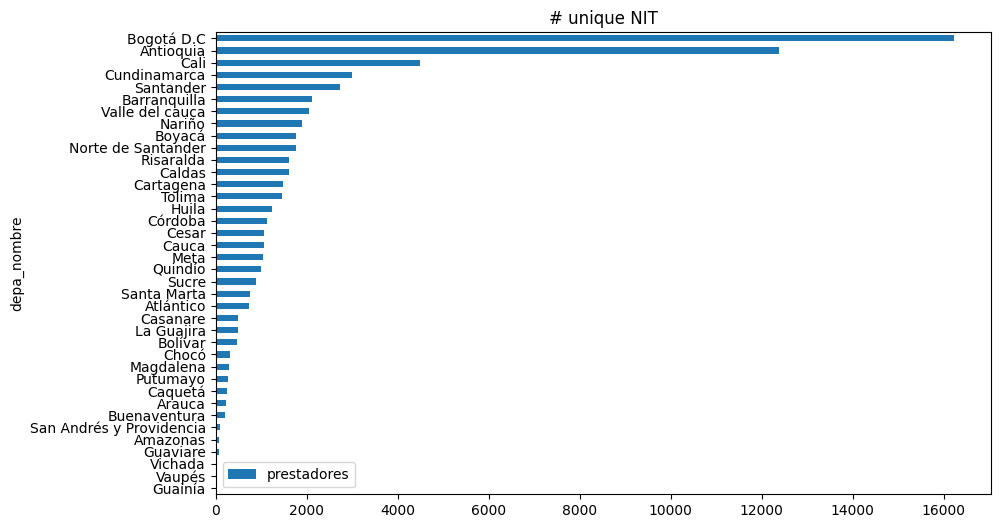

In [31]:
data["prestadores"].groupby(["depa_nombre"]).agg(prestadores=("nits_nit","nunique")).sort_values("prestadores").plot(kind="barh", figsize=(10,6), title="# unique NIT");

In [21]:
print("END... ", round((time.time()-start_i)/60,1),"min.")

END...  14.6 min.
